In [1]:
from scipy import special
import numpy as np 
import matplotlib.pyplot as plt
from units import *

In [2]:
#SI base units
s = 1
kg = 1
m = 1
A = 1

#derived units
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

#with prefixes
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
pF = 1e-12 * F
ms = 1e-3 * s

rate = 10 * Hz    # spike rate
bin_size = 1 * ms # bin size 
tmax = 1 * s      # the total length of the spike train

In [3]:
def homogeneous_poisson(rate, tmax, bin_size):
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    spikes = np.random.rand(nbins) < prob_of_spike
    return spikes * 1

Text(0.5, 0, 'time (s)')

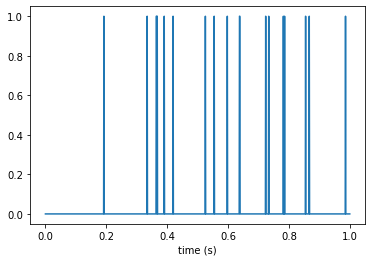

In [4]:
spikes_poisson = homogeneous_poisson(rate, tmax, bin_size)
time = np.arange(len(spikes_poisson)) * bin_size
plt.plot(time, spikes_poisson)
plt.xlabel('time (s)')
     

In [5]:
def homogeneous_poisson_generator(n_trials, rate, tmax, bin_size):
    for i in range(n_trials):
        yield homogeneous_poisson(rate, tmax, bin_size)

In [6]:
spike_trains = list(homogeneous_poisson_generator(1000, rate, tmax, bin_size))

In [7]:
n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(1000, rate, tmax, bin_size)] 

Text(0, 0.5, 'number of realisations')

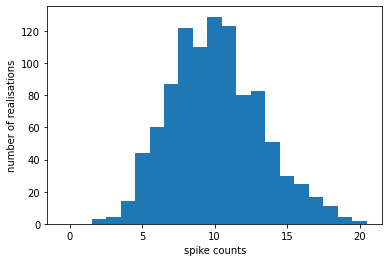

In [8]:
n_spikes = np.array(n_spikes)
bin_edges =  np.arange(n_spikes.max() + 1) - 0.5
plt.hist(n_spikes, bin_edges);
plt.xlabel('spike counts')
plt.ylabel('number of realisations')


In [9]:
print("Mean: {:.1f}".format(n_spikes.mean()))
print("Variance: {:.1f}".format(n_spikes.var()))
print("Rate * train length: {:.1f}".format(rate * tmax))
     

Mean: 10.1
Variance: 10.2
Rate * train length: 10.0


In [10]:
ff = np.var(n_spikes)/np.mean(n_spikes)
print("Fano factor: {:.1f}".format(ff))
     

Fano factor: 1.0


In [11]:
def poisson_prob(k, lam):
    return lam**k/special.factorial(k)*np.exp(-lam)

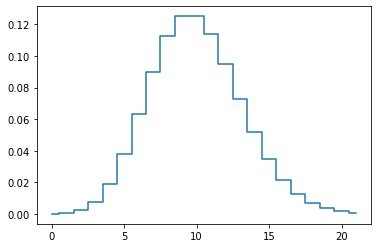

In [12]:
lam = rate * tmax
k = bin_edges + 0.5
prob = poisson_prob(k, lam)
plt.plot(k, prob, drawstyle='steps-mid');

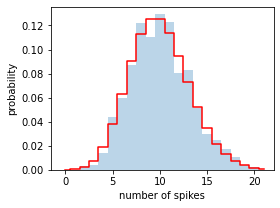

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.hist(n_spikes, bin_edges, density=True, alpha=.3)
ax.plot(k, prob, drawstyle='steps-mid', c='r')
ax.set_xlabel('number of spikes')
ax.set_ylabel('probability')

plt.show()

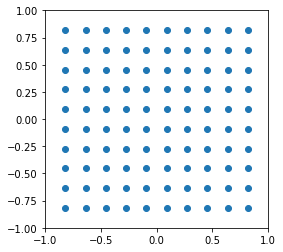

In [14]:
def generate_rf_grid(n, low, high):
    step = (high-low) / (n)
    start = low + step
    stop = high 
    grid = []
    for x in np.linspace(low, high, num=n+2)[1:-1]:
        for y in np.linspace(low, high, num=n+2)[1:-1]:
            grid.append([x, y])
            
    return np.array(grid)
            
grid = generate_rf_grid(10, -1, 1)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(grid[:,0], grid[:,1])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.show()

In [108]:
## gaussian rf fuction
def gaussian_rf(x, y, strength, spread):
    dist = np.linalg.norm(x-y)
    return strength * np.exp(-(dist)**2 / (2*(spread**2)))

def encoder(stim_loc, rf_grid, strength=1, spread=.1, noise_rate=.1, scale=10):
    signal = np.array([gaussian_rf(rf_loc, stim_loc, strength, spread) for rf_loc in rf_grid])
    noise = np.ones(len(signal)) * noise_rate
    lam = signal + noise
    lam /= lam.sum() # normalize
    return lam * scale

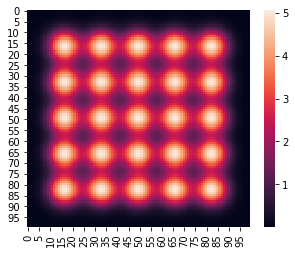

In [91]:
X = np.zeros((100, 100, 2))
for i,x in enumerate(np.linspace(-1, 1, 100)):
    for j,y in enumerate(np.linspace(-1, 1, 100)):
        X[i, j, 0] =  x
        X[i, j, 1] = y

n = 5
low, high = -1, 1
rf_grid = generate_rf_grid(n, low, high)

strength, spread = 5, .1
field = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        activation = np.array([gaussian_rf(X[i,j], y, strength, spread) for y in rf_grid])
        field[i][j] = activation.sum()
    
    
    
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(field, ax=ax)

plt.show()

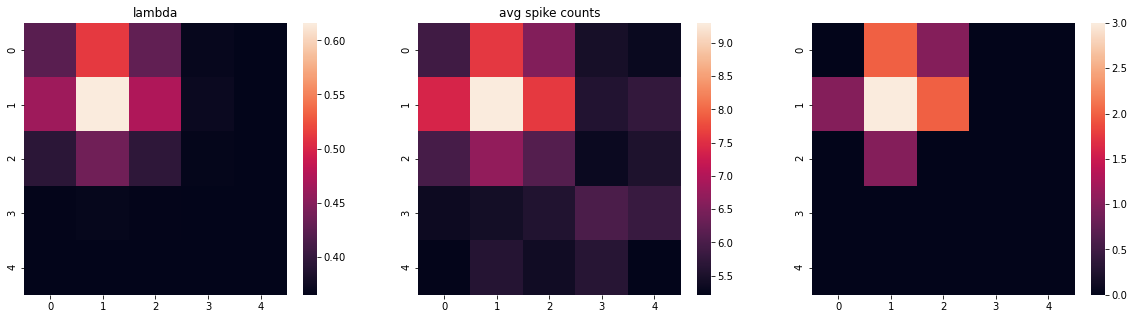

In [155]:
strength = 5
spread = .25
noise_rate = 7
scale=10

stim = np.array([-.4, -.325])
lam = encoder(stim, rf_grid, strength=strength, spread=spread, noise_rate=noise_rate, scale=scale)

bin_size = 1 * ms # bin size 
tmax = 3 * s      # the total length of the spike train

avg_spikes = np.zeros(len(lam))
for i,rate in enumerate(lam):
    n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(100, rate, tmax, bin_size)]
    avg_spikes[i] = np.mean(n_spikes)

avg_spikes_rounded = np.round(avg_spikes - avg_spikes.mean()).astype('int')
avg_spikes_rounded[avg_spikes_rounded < 0] = 0



    
fig, ax = plt.subplots(figsize=(20,5), ncols=3)
s = int(np.sqrt(len(lam)))
sns.heatmap(np.reshape(lam, (s,s)), ax=ax[0])
sns.heatmap(np.reshape(avg_spikes, (s,s)), ax=ax[1])
sns.heatmap(np.reshape(avg_spikes_rounded, (s,s)), ax=ax[2])


ax[0].set_title('lambda')
ax[1].set_title('avg spike counts')

plt.show()

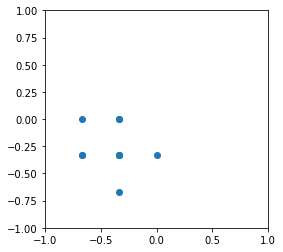

In [156]:
obs = np.ones((int(avg_spikes_rounded.sum()), 2))

count = 0
for xy, n in zip(rf_grid, avg_spikes_rounded):
    for _ in range(n):
        obs[count] = xy
        count +=1
        
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(obs[:,0], obs[:,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

plt.show()

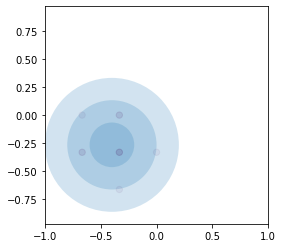

In [157]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance),2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=.05)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, alpha=.05)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
        
gmm = GaussianMixture(n_components=1, covariance_type='spherical').fit(obs)

fig, ax = plt.subplots(figsize=(4, 4))
plot_gmm(gmm, obs, ax=ax)


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.show()

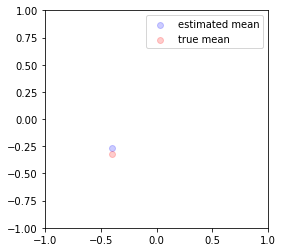

In [158]:
mean = gmm.means_[0]

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(mean[0], mean[1], c='blue', alpha=.2, label='estimated mean')
ax.scatter(stim[0], stim[1], c='red', alpha=.2, label='true mean')

ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))

plt.legend()
plt.show()

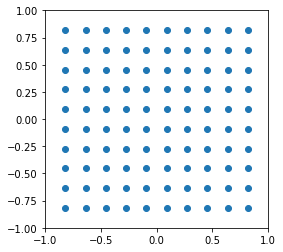

array([[-0.81818182, -0.81818182],
       [-0.81818182, -0.63636364],
       [-0.81818182, -0.45454545],
       [-0.81818182, -0.27272727],
       [-0.81818182, -0.09090909],
       [-0.81818182,  0.09090909],
       [-0.81818182,  0.27272727],
       [-0.81818182,  0.45454545],
       [-0.81818182,  0.63636364],
       [-0.81818182,  0.81818182],
       [-0.63636364, -0.81818182],
       [-0.63636364, -0.63636364],
       [-0.63636364, -0.45454545],
       [-0.63636364, -0.27272727],
       [-0.63636364, -0.09090909],
       [-0.63636364,  0.09090909],
       [-0.63636364,  0.27272727],
       [-0.63636364,  0.45454545],
       [-0.63636364,  0.63636364],
       [-0.63636364,  0.81818182],
       [-0.45454545, -0.81818182],
       [-0.45454545, -0.63636364],
       [-0.45454545, -0.45454545],
       [-0.45454545, -0.27272727],
       [-0.45454545, -0.09090909],
       [-0.45454545,  0.09090909],
       [-0.45454545,  0.27272727],
       [-0.45454545,  0.45454545],
       [-0.45454545,

In [58]:
def generate_rf_grid(n, low, high):
    step = (high-low) / (n)
    start = low + step
    stop = high 
    grid = []
    for x in np.linspace(low, high, num=n+2)[1:-1]:
        for y in np.linspace(low, high, num=n+2)[1:-1]:
            grid.append([x, y])
            
    return np.array(grid)
            
grid = generate_rf_grid(10, -1, 1)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(grid[:,0], grid[:,1])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.show()

grid

In [31]:
from src.core import make_knot_grid, make_curve, sample_knots
from src.visualization import pretty_picture_of_curve_ax

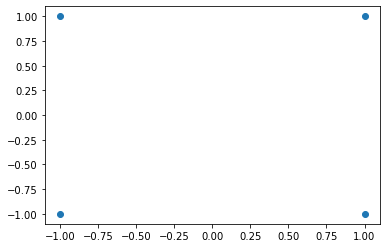

In [35]:
grid = make_knot_grid(2, -1, 1)
plt.scatter(grid[:,0], grid[:,1])

In [32]:
knot_grid = make_knot_grid(10, -1, 1)
knots = sample_knots(knot_grid, 4)

In [28]:
knot_grid

NameError: name 'knot_grid' is not defined

In [27]:
n_spikes

array([ 6,  9, 13,  8,  4,  5,  7,  9, 11,  4,  4,  8, 12,  7, 11, 13, 15,
        8,  7, 10, 10, 14,  9,  6, 16,  7,  5,  4, 12,  7, 10,  8,  7,  9,
       10, 10, 12,  9,  5, 15, 11, 10,  9, 10, 19, 10, 18,  6,  9,  6, 15,
       15, 10, 11, 14,  9,  8, 19, 10, 17, 10, 11, 16,  4,  8, 11, 14, 11,
       17, 11, 11, 11,  6, 13, 12,  7,  5,  8, 10,  8, 10,  7, 13, 13,  8,
        9, 13, 17, 10,  9,  8, 12, 15, 14,  8,  3,  9,  7, 10,  7, 10,  9,
        7, 11,  9,  9, 18, 12, 11, 17, 13,  6,  5,  9,  7,  3, 17, 10,  9,
       12, 14, 11, 10, 10, 10, 10, 12,  5, 12, 10,  7, 15,  7,  9, 11,  6,
        9, 13,  8,  4, 16, 11,  8, 12, 10, 10,  9,  9, 10,  8,  9,  8,  6,
       10,  9, 12,  9,  9,  8, 11, 10, 15, 11, 13,  9,  9, 10, 11, 12, 11,
        7, 15, 10, 11,  5, 10,  6,  8,  6, 10, 14, 12, 10, 10,  9,  7, 11,
        8,  8, 11, 14, 11,  8, 11,  8, 10,  4, 13,  7,  9,  9,  7, 10, 11,
       14,  8, 17, 10, 15,  6, 13, 10, 10, 12, 10,  9,  9,  9,  6,  8,  6,
        6,  7, 11,  5,  9